In [1]:
# %reset -f
from random import sample, choices
import itertools
import pandas as pd
import numpy as np
from utils import *
from wavhandler import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
filename = 'mosquitos.csv'
df = pd.read_csv(os.path.join(TEMP_DATADIR, filename), delimiter=';', index_col=0)

In [40]:
print(df.shape)
df.sample(5)

(279566, 17)


,fname,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label,date
11785,F170211_202249_002_G_050,0.085131,0.101923,1.880144e-02,509.765625,1009.765625,1514.648438,0.057471,0.040619,0.000000,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti,20170211
46619,F170209_091542_030_G_050,0.119675,0.000494,1.785413e-07,1290.039062,2586.914062,3809.570312,0.012112,0.005663,0.000128,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti,20170209
169800,F170314_141453_086_G_050_T_26.6_H_76.0,0.162690,0.060494,4.534701e-03,548.828125,1097.656250,1649.414062,0.039146,0.021352,0.018650,/home/kalfasyan/data/insects/Wingbeats/An. ara...,9,9,26.6,76.0,An. arabiensis,20170314
278963,F161219_194755_164_G_050,0.132782,0.023503,1.888503e-02,458.984375,942.382812,1409.179688,0.069149,0.041969,0.013514,/home/kalfasyan/data/insects/Wingbeats/C. quin...,9,5,NaN,NaN,C. quinquefasciatus,20161219
28165,F170209_221611_100_G_050,0.143694,0.066292,4.750865e-04,583.007812,1192.382812,1693.359375,0.041876,0.029894,0.011534,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti,20170209


In [14]:
# CREATING DATE COLUMN
df['date'] = df['fname'].apply(lambda x: pd.to_datetime(x.split('_')[0] + x.split('_')[1], format='F%y%m%d%H%M%S'))
df['date'] = df.date.dt.to_period('d').apply(lambda x: x.strftime('%Y%m%d'))
print(df.date.head(2))

0    20170209
1    20170209
Name: date, dtype: object


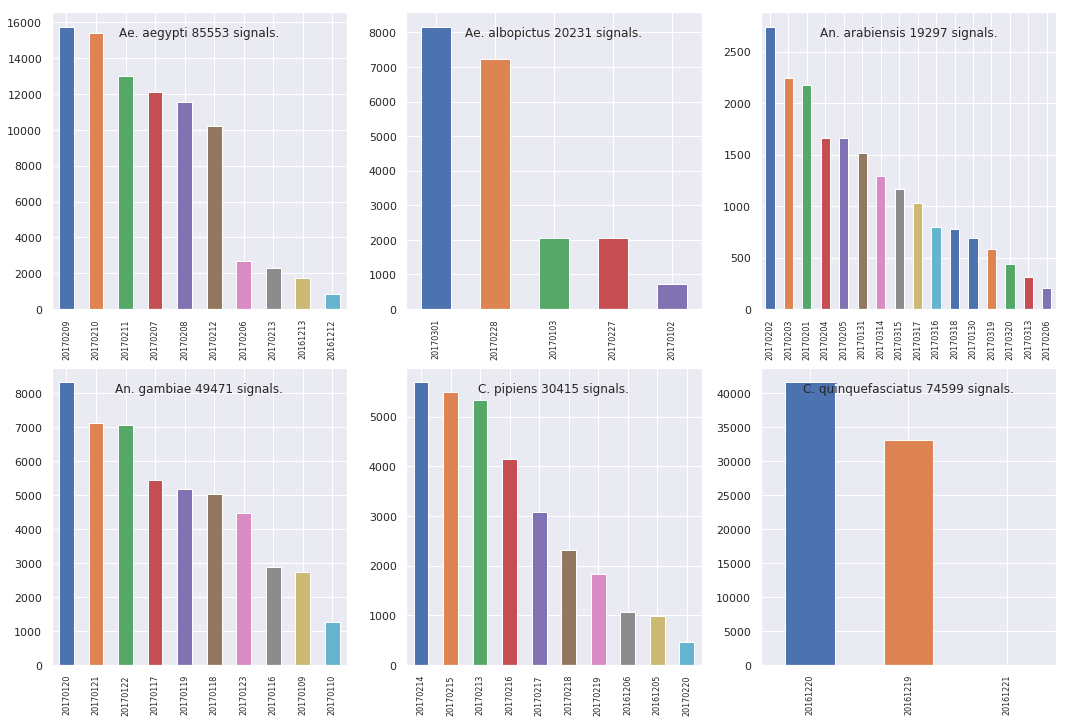

In [16]:
plt.figure(figsize=(18,12))
plt.tight_layout()
for q, (i, sub) in enumerate(df.groupby('label')):
    plt.subplot(2,3,q+1)
    plt.title(sub.label.unique()[0] +' '+ str(sub.shape[0])+' signals.', y=0.9)
    sub.date.value_counts().plot(kind='bar')
    plt.xticks(rotation=90, fontsize=8)

Example periods for class "C. pipiens": 	['20170214', '20170215', '20170213']
Example combinations for periods of class "C. pipiens": 	[('20170214', '20170214'), ('20170214', '20170215'), ('20170214', '20170213')]
Total nr. of combinations: 	55


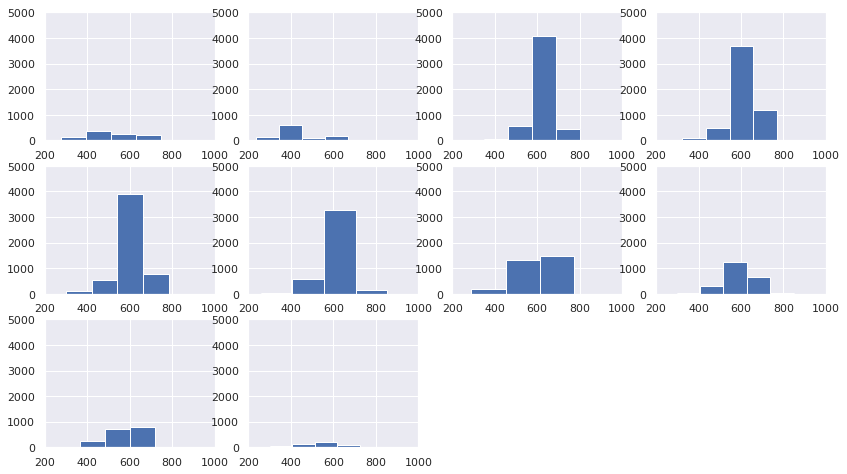

In [39]:
class_label = 'C. pipiens'
periods = df[df.label==class_label].date.value_counts().index.tolist()
periods = [periods[i] for i in range(len(periods))]
print('Example periods for class \"{}\": \t{}'.format(class_label, periods[:3]))

pair_combs = []
for i in itertools.combinations_with_replacement(periods, r=2):
    pair_combs.append(i)
print('Example combinations for periods of class \"{}\": \t{}'.format(class_label, pair_combs[:3]))
print('Total nr. of combinations: \t{}'.format(len(pair_combs)))

plt.figure(figsize=(14,8))
plt.tight_layout()
for i, (day, sub) in enumerate(df[df.label==class_label].groupby('date')):
    plt.subplot(3,4,i+1)
    sub.fr0.hist()
    plt.xlim(200, 1000)
    plt.ylim(0,5000)